In [4]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget

import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
data_dir = "../data"
for f in os.listdir(data_dir):
    print(f)

config.json
config_half.json
kowiki.csv.gz
kowiki.model
kowiki.txt
kowiki.vocab
kowiki_bert_0.json
kowiki_gpt.json
ratings_test.json
ratings_test.txt
ratings_train.json
ratings_train.txt
save_bert_pretrain.pth
save_gpt_pretrain.pth


In [6]:
# vocab loading
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [7]:
""" configuration json을 읽어들이는 class """
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [8]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


In [9]:
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(100000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]
    
    sinusoid_table = np.array([get_posi_angle_vec(i+seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

### size() 함수를 쓰기 위해서 torch로 q와 k를 만들어준다.

In [49]:
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

inputs = []
for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    inputs.append(torch.tensor(ids))
    print(pieces)
# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
k = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
k.size()

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']


torch.Size([2, 8])

In [42]:
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

inputs = []
for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    inputs.append(torch.tensor(ids))
    print(pieces)
# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
q = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
q.size()

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']


torch.Size([2, 8])

In [51]:
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k)
    return pad_attn_mask

In [52]:
#torch.Size([2, 8]), torch.Size([2, 8])
get_attn_pad_mask(q, k , 1)

tensor([[[False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False]],

        [[False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, F

In [48]:
#torch.Size([2, 9]), torch.Size([2, 8])
get_attn_pad_mask(q, k , 2)

tensor([[[False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False]],

        [[False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False

이 함수를 통해서 위와 같이 크기를 맞줘줘서 나중에 내적을 쉽게 할 수 있다.

### Decoder Mask를 구하기

-----------------------

unsqueeze(-1) : 가로 새로 바구기
```
torch.unsqueeze(x, 0)
tensor([[ 1,  2,  3,  4]])
torch.unsqueeze(x, 1)
tensor([[ 1],
        [ 2],
        [ 3],
        [ 4]])
```
-----------

torch.ones_like : 가로안 만큼 1 만들기


------------------

triu(diagonal=1) : 뭉쳐 있는 배열들을 보기 쉽게 아래로 내려주기
```
np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], -1)
array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 0,  8,  9],
       [ 0,  0, 12]])
```
--------------------

torch.triu(a, diagonal=1) # 아래는 다 0으로 조지기
```
tensor([[ 0.0000,  0.5207,  2.0049],
        [ 0.0000,  0.0000,  0.6602],
        [ 0.0000,  0.0000,  0.0000]])
```

In [53]:
def get_dttn_decoder_mask(seq):
    # 빈 마스크를 만들어주고 (크기만큼만)
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    # 행렬의 위쪽 삼각형 부분(2-D)
    subsequent_mask = subsequent_mask.triu(diagonal=1)
    return subsequent_mask

###### ScaledDotProductAttention
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/scale_dot_product_attention.png)

In [61]:
q, q.transpose(-1, -2)

(tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
         [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]]),
 tensor([[3091,  212],
         [3604, 3605],
         [ 206,   53],
         [3958, 3832],
         [3760, 3596],
         [3590, 3682],
         [   0, 3760],
         [   0, 3590]]))

In [73]:
# masked_fill_ 역할은 위치에 있는 것들 제거하는거

```
In [3]: mask = torch.tensor([[[1, 0]], [[0, 1]]], dtype=torch.uint8)

In [4]: mask.shape
Out[4]: torch.Size([2, 1, 2])

In [5]: x = torch.randn(2, 2)

In [6]: x, mask = torch.broadcast_tensors(x, mask)

In [7]: mask.shape
Out[7]: torch.Size([2, 2, 2])

In [8]: x.is_contiguous()
Out[8]: False

In [9]: x.masked_fill(mask, 0)  # This should be the correct behavior
Out[9]: 
tensor([[[ 0.0000,  0.9482],
         [ 0.0000,  0.0719]],

        [[ 0.6267,  0.0000],
         [-0.6296,  0.0000]]])
```

In [74]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        
        context = torch.matmul(attn_prob, V)
        return context, attn_prob

###### MultiHeadAttention
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/multi_head_attention.png)

self.config.n_head * self.config.d_head 만큼 들어오고 


self.config.d_hidn 만큼 멀티해드 어텐션 저 위에 h가 이것이여

In [80]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head) / view는 크기를 조절하는 거 일단 batch는 고정하고 seq는 자유롭게 r그리고 n_head 고정
        # 마무리로 늘려주기 까지
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_q_seq, n_k_seq)
        # unsqueeze(1) 살려두는 것들은 1로 한 줄로 만드는건가
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)
        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob


sizes (torch.Size or python:int...) – The number of times to repeat this tensor along each dimension

Example:
```
>>> x = torch.tensor([1, 2, 3])
>>> x.repeat(4, 2)
tensor([[ 1,  2,  3,  1,  2,  3],
        [ 1,  2,  3,  1,  2,  3],
        [ 1,  2,  3,  1,  2,  3],
        [ 1,  2,  3,  1,  2,  3]])
>>> x.repeat(4, 2, 1).size()
torch.Size([4, 2, 3])
```

###### PoswiseFeedForwardNet
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/feed-forward.png)

In [82]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

#### 7. Encoder
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/encoder.png)

###### EncoderLayer

In [83]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

###### Encoder

In [85]:
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        # 멀티헤드 어텐션으로 위치 찾아주기
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        # 포지션 임베딩 때리고
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze = True)
        # 레이어 수만큼 반복
        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
        
    def forward(self, inputs):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
        
        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)
        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)
        
        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

#### 8. Decoder
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/decoder.png)

In [86]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)

    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(defc_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_nrom1(dec_inputsn + self_att_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + fnn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

###### Decoder

In [18]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

#### 9. Transformer

In [19]:
""" transformer """
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

#### 10. Naver 영화 분류 모델

In [20]:
""" naver movie classfication """
class MovieClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = Transformer(self.config)
        self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)
        # (bs, d_hidn)
        dec_outputs, _ = torch.max(dec_outputs, dim=1)
        # (bs, n_output)
        logits = self.projection(dec_outputs)
        # (bs, n_output), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

#### 11. 네이버 영화 분류 데이터


In [21]:
""" 영화 분류 데이터셋 """
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])
    
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor([self.vocab.piece_to_id("[BOS]")]))

In [23]:
""" movie data collate_fn """
def movie_collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
        dec_inputs,
    ]
    return batch

In [24]:
""" 데이터 로더 """
batch_size = 128
train_dataset = MovieDataSet(vocab, f"{data_dir}/ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, f"{data_dir}/ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

Loading ../data/ratings_test.json: 100%|██████████████████████████████████| 49997/49997 [00:02<00:00, 18014.23 lines/s]


#### 11. 네이버 영화 분류 데이터 학습

In [25]:
""" 모델 epoch 평가 """
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm_notebook(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            _, indices = logits.max(1)

            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0


In [26]:
""" 모델 epoch 학습 """
def train_epoch(config, epoch, model, criterion, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm_notebook(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, value in enumerate(train_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]

            loss = criterion(logits, labels)
            loss_val = loss.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [27]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda'), 'n_output': 2}


In [0]:
model = MovieClassification(config)
model.to(config.device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_epoch, best_loss, best_score = 0, 0, 0
losses, scores = [], []
for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader)
    score = eval_epoch(config, model, test_loader)

    losses.append(loss)
    scores.append(score)

    if best_score < score:
        best_epoch, best_loss, best_score = epoch, loss, score
print(f">>>> epoch={best_epoch}, loss={best_loss:.5f}, socre={best_score:.5f}")

,loss,score
0,0.484429,0.802268
1,0.403221,0.817009
2,0.375795,0.812249
3,0.355647,0.826450
4,0.334026,0.829990
5,0.313187,0.827850
6,0.291726,0.834270
7,0.268704,0.834070
8,0.245113,0.834710
9,0.220757,0.833990


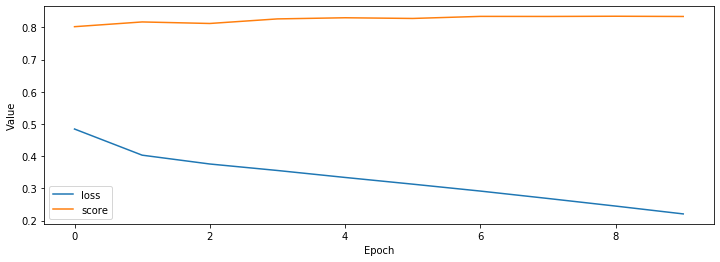

In [0]:
# table
data = {
    "loss": losses,
    "score": scores
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.plot(scores, label="score")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()